<a href="https://colab.research.google.com/github/Jameschen7/Decision_Tree_Random_Forests/blob/master/Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Decision Tree**
---


## Implement ID3 Decision Tree Algorithm


### Goal
This section will implement the **ID3 decision tree algorithm** along with its pruning process. The code is modified from my CSE151 class. The resulting decision tree is a binary classifier, but simple **One V.S. All** or **All V.S. All reduction** can be further implemented to expand the usage of the code onto multi-class classifications.

In [0]:
import numpy as np
import math
import queue
from scipy import stats

train_file = "/content/drive/My Drive/Colab Notebooks/DecisionTree&RandomForests/train.txt"
validate_file = "/content/drive/My Drive/Colab Notebooks/DecisionTree&RandomForests/validation.txt"
test_file = "/content/drive/My Drive/Colab Notebooks/DecisionTree&RandomForests/test.txt"

In [0]:
def read_data(f_name):
    """
    read data as array from file

    :param f_name: input file name
    :return: the feature array and label array
    """
    data = np.loadtxt(f_name);
    return data[:, :-1], data[:, -1]

In [0]:
# define the Node class in the decision tree
class Node():
    c_y = None;
    c_n = None;

    def __init__(self, data=None, label=None):
        self.data = data  # the dataset passing through this node
        self.label = label  # the corresponding set of labels of the dataset

        self.feature_index = None  # which feature to split
        self.threshold = None        # smaller than or equal to which threshold
        self.is_leaf = False            # leaf or not
        self.predict = 0                 # if leaf, what to predict

    def set_rule(self, feature_index, threshold):
        """
        set the splitting rule
        """
        self.feature_index = feature_index
        self.threshold = threshold

    def set_leaf(self, predict):
        """
        set this node to be a leaf
        """
        self.is_leaf = True
        self.predict = predict

    def print(self):
        print("number remained: ", len(self.label), " node is_leaf? ", self.is_leaf, " predict: ", self.predict,
              "feature_index: ", self.feature_index, " threshold: ", self.threshold)

In [0]:
# the Decision tree class containing the ID3 algorithm
class Decision_Tree():
    root = None
    def __init__(self, train_data, train_label):
        self.root = Node(train_data, train_label)

    def build_node(self, curr):
        """
        A recursive helper method to build the ID3 decision tree node by node based on the 
        information gain.

        :param curr: which node to be builded
        :return: the feature array and label array
        """
        if (self.is_pure(curr.label)): # if it's already a leaf
            curr.set_leaf(curr.label[0])
        else:  # else find the feature and the threshold resulting in the largest information gain
            feature_index, threshold = self.split(curr.data, curr.label)
            curr.set_rule(feature_index, threshold)

            data_y = curr.data[curr.data[:, feature_index] <= threshold]
            data_n = curr.data[curr.data[:, feature_index] > threshold]
            label_y = curr.label[curr.data[:, feature_index] <= threshold]
            label_n = curr.label[curr.data[:, feature_index] > threshold]
            curr.c_y = Node(data_y, label_y)
            curr.c_n = Node(data_n, label_n)
            self.build_node(curr.c_y)
            self.build_node(curr.c_n)

    def build(self):
        """
        build the decision tree based on the input training data
        :return: the decision tree built
        """
        self.build_node(self.root)
        return self

    def single_test(self, test):
        """
        predict one test data
        """
        curr = self.root
        while (not curr.is_leaf):
            if (test[curr.feature_index] <= curr.threshold):
                curr = curr.c_y
            else:
                curr = curr.c_n
        return curr.predict

    def test(self, test_data, test_label):
        assert test_data.shape[1] == self.root.data.shape[1], "dimension does not match"
        return sum(list(map(self.single_test, test_data)) != test_label)/len(test_label)
    
    def prune(self, validata_data, validate_label):
        """
        post prune the decision tree in a top-down level-order algorithm that replaces any 
        subtree with a terminal node (predicting the mode of its labels) if doing so increase 
        the test accuracy on the validation data.
        """
        assert self.root is not None

        que = queue.Queue() # iterate the decision tree down by BFS
        que.put_nowait(self.root)
        old_error = self.test(validata_data, validate_label)
        count_n = 1

        # prune the whole decision tree
        while (que.qsize() > 0):
            curr = que.get_nowait()
            if (curr.is_leaf):
                continue

            curr.is_leaf = True
            curr.predict = stats.mode(curr.label).mode[0] # the majority label
            if (self.test(validata_data, validate_label) <= old_error):
                curr.c_y = None
                curr.c_n = None
            else: # change the fields back
                curr.is_leaf = False
                curr.predict = 0
                que.put_nowait(curr.c_y)
                que.put_nowait(curr.c_n)

    def is_pure(self, labels):
        assert labels.shape[0] > 0, "label list length is 0"
        return labels.tolist().count(labels[0]) == labels.shape[0]

    def entropy(self, data):
        freqs = np.unique(data, return_counts=True)[1]/len(data)
        return sum(map(lambda f: -1 * f * math.log(f), freqs))

    def cond_entropy(self, data, label, feature_index, threshold):
        label_y = label[data[:, feature_index] <= threshold]
        label_n = label[data[:, feature_index] > threshold]
        prob_y = len(label_y)/len(label)
        return prob_y * self.entropy(label_y) + (1 - prob_y) * self.entropy(label_n)

    def split(self, data, label):
        """
        find the splitting feature and threshold for this data and label lists
        :param data: the dataset
        :param label: the corresponding label
        :return: the feature index, threshold that will maximize the information gain
        """
        # def cal_infomation_gain(dim):
        #     data_dim = np.unique(data[:, dim])
        #     thresholds = (data_dim[:-1] + data_dim[1:]) / 2
        #     if (len(thresholds) == 1):
        #         return 
        #     result_entropy = list(map(lambda threshold: self.cond_entropy(data, label, dim, threshold), thresholds))
        #     print(len(result_entropy))
        #     min_dim = np.argsort(result_entropy)[0]
        #     return (result_entropy[min_dim], thresholds[min_dim])
        # result = np.array(list(map(cal_infomation_gain, range(data.shape[1])) ))
        # min_index = np.argsort(result[:, 0])[0]
        # return min_index, result[min_index, 1]

        min_cond_entropy = 1
        best_dim = 0
        best_threshold = 0
        for dim in range(data.shape[1]): # the dimension/feature_index
            data_dim = np.unique(data[:, dim])
            for thresh_i in range(len(data_dim)-1):
                threshold = (data_dim[thresh_i]+data_dim[thresh_i+1])/2
                new_cond_entropy = self.cond_entropy(data, label, dim, threshold)
                if (new_cond_entropy < min_cond_entropy):
                    min_cond_entropy = new_cond_entropy
                    best_dim = dim
                    best_threshold = threshold
        return best_dim, best_threshold

### Test

In [0]:
# train, test, validation data
train_data, train_label = read_data(train_file)
test_data, test_label = read_data(test_file)
validata_data, validate_label = read_data(validate_file)

In [0]:
dtree = Decision_Tree(train_data, train_label).build()

In [0]:
# test train data
print("test training")
print(dtree.test(train_data, train_label))

test training
0.0


In [0]:
# test test data
print("test test")
print(dtree.test(test_data, test_label))

test test
0.171


In [0]:
# test validation data
print("test validation")
print(dtree.test(validata_data, validate_label))

test validation
0.178


In [0]:
# test pruning on validation + test data
dtree.prune(validata_data, validate_label)

print("test test data")
print(dtree.test(test_data, test_label))
print("test validation")
print(dtree.test(validata_data, validate_label))

test test data
0.103
test validation
0.107


## Test the Decision Tree from sklearn.tree

The resulting score is quite similar to what my decision tree algorithm outputs above.

In [0]:
from sklearn import  tree, datasets
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [0]:
train_data, train_label = read_data(train_file)
test_data, test_label = read_data(test_file)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
print("tree depth: ", clf.get_depth(), ", # of leaves: ", clf.get_n_leaves())

tree depth:  27 , # of leaves:  241


In [0]:
# print(sum(clf.predict(test_data) != test_label) / len(test_label))
clf.score(test_data, test_label)

0.828

In [0]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
clf.score(test_data, test_label)


0.83

## The Effect of the Number of leaves on the Test Accuracy

### Goal
Since the actual building algorithm employs some random elements (as demonstrated in the last two output test scores) in the order of evaluation of each feature (due to the pseudo-random [feature shuffle](https://github.com/scikit-learn/scikit-learn/issues/2386#issuecomment-23147704)) and the process of tie breaking--if there is a tie then choose the first feature investigated to split, the **random_state** parameter will have effect on the final tree struture and number of leaves, ultimately affecting the test accuracy. Utilizing this design in the tree growing algorithm, we can briefly study how the number of terminal nodes (complexity) correlates with the test accuracy.

In [0]:
leaves_counts = [] # store different number of leaves
accuracy = [] # store the correponding accuracy

# train data
train_data, train_label = read_data(train_file)
test_data, test_label = read_data(test_file)

# iris = datasets.load_breast_cancer()
# train_data, test_data, train_label, test_label = train_test_split(iris.data, iris.target, random_state=0)

clf = tree.DecisionTreeClassifier() # not specifying the random_state
for _ in range(1000):
    clf.fit(train_data, train_label)
    leaves_count = clf.get_n_leaves()
    score = clf.score(test_data, test_label)
    if (leaves_count, score) not in zip(leaves_counts, accuracy):
        leaves_counts.append(leaves_count)
        accuracy.append(score)

len(leaves_counts)

281

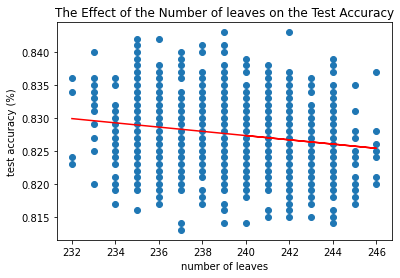

In [0]:
# draw a scatter plot
fig, ax = plt.subplots()
ax.set_xlabel("number of leaves")
ax.set_ylabel("test accuracy (%)")
ax.set_title("The Effect of the Number of leaves on the Test Accuracy")
# ax.plot(leaves_counts, accuracy, marker='o', linestyle=None)
ax.scatter(leaves_counts, accuracy, marker='o') 

# draw the linear least-square trend line
z = np.polyfit(leaves_counts, accuracy, 1)
p = np.poly1d(z)
ax.plot(leaves_counts, p(leaves_counts), "r-")
plt.show()

### Conclusion
The resultant least-sqaure trend line corresponds with the general idea that a simpler decision tree with fewer leaves can be better generalized to unseen test data. This is also why pruning the decision tree after the training algorithm is so useful.


## Prune the Decision Tree from sklearn.tree with Cost-complexity Pruning


### Goal
By comparing different ccp_alpha values, which measures how costly the complexity is, we can find the optimal ccp_alpha to post prune the decision tree. The code in this section is modified from an [exmaple](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py) at scikit-learn.org.

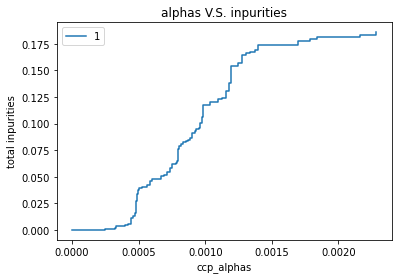

89

In [0]:
path = clf.cost_complexity_pruning_path(train_data, train_label)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots(1,1)
ax.plot(ccp_alphas[:-1], impurities[:-1], drawstyle="steps-post", label="1" )
ax.set_xlabel("ccp_alphas")
ax.set_ylabel("total inpurities")
ax.legend()
ax.set_title("alphas V.S. inpurities")
plt.show()

len(impurities)

In [0]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf.fit(train_data, train_label)
    clfs.append(clf)

print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.29588145417923295


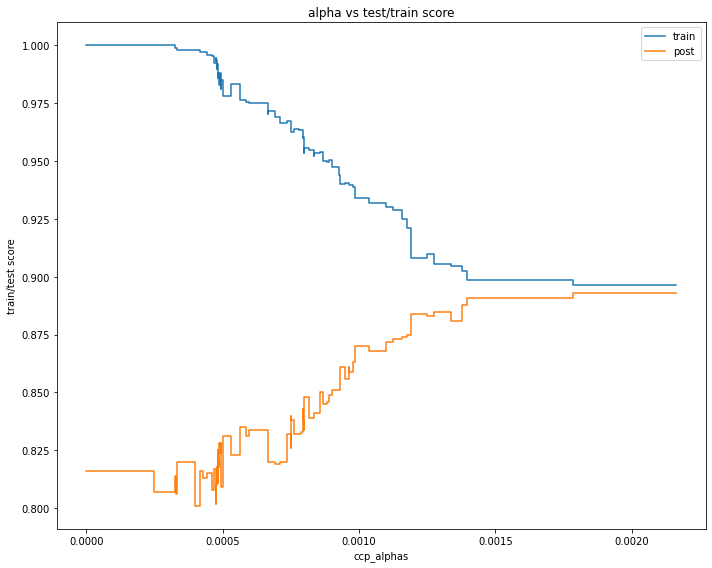

In [0]:
# since the last value in ccp_alpha list only contains the root node, often it will just be an outlier
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

train_score = [clf.score(train_data, train_label) for clf in clfs]
test_score = [clf.score(validata_data, validate_label) for clf in clfs]

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(ccp_alphas, train_score, drawstyle="steps-post", label="train")
ax.plot(ccp_alphas, test_score, drawstyle="steps-post", label="post")
ax.set_xlabel("ccp_alphas")
ax.set_ylabel("train/test score")
ax.set_title("alpha vs test/train score")
# fig.tight_layout()
ax.legend()
plt.show()


### Result
With the optimal ccp_alpha value, the pruned decision tree achieves the same best accuracy (0.103) as the one pruned by the greedy pruing algorithm implemented by myself above.

In [0]:
pruned_clf = tree.DecisionTreeClassifier(ccp_alpha=0.0020) # the best ccp_alpha value
pruned_clf.fit(train_data, train_label)
print("test error: ", sum(pruned_clf.predict(test_data)!=test_label)/len(test_label))
print("score: ", pruned_clf.score(test_data, test_label))

test error:  0.103
score:  0.897


# Random Decision Forests

The algorithm of the random decision forests is first proposed by [Tin Kam Ho](https://web.archive.org/web/20160417030218/http://ect.bell-labs.com/who/tkh/publications/papers/odt.pdf), which is able to fix the overfitting problem of individual decision tree and aims at achieving high performance on both the training and the unseen testing data. In other words, this kind of random decision forests breaks the bias-variance tradeoff for the concept class of decision trees. The paper mentions two algorithms to development two oblique decision trees and how to systematically build uncorrelated individual decision tree in the forest, which is essentially the key of random forests.


## Test sklearn randon decision forests
### Important Parameters
The random decision forests in sklearn.ensemble.RandomForestClassifier has some important parameters:
* bootstrap (default=True): samples are drawn with replacement
    * max_samples: If bootstrap is True, the number of samples to draw, default is x.shape[0]
* n_estimators (default=100): The number of decision trees in the forest.
* Max_feature: (default=sqrt(n_features)): max number of features to be considered during splitting
* For fully developing the trees: (default)
    * max_depth=None, meaning no limit
    * min_samples_split=2, meaning the minimum number of different labels for splitting
* criterion: (default=”gini”) the criterion for splitting a tree (Gini or Entropy). [Gini](https://bambielli.com/til/2017-10-29-gini-impurity/): sum of P(i) * (1 - P(i))
* ccp_alpha: for Minimal Cost-Complexity Pruning

### Result
Using the random decision forest classifier from sklearn with default parameters, we directly obtain the lowest error rate so far based on a single pruned decision tree implemented by my own and by sklearn.



In [0]:
from sklearn.ensemble import RandomForestClassifier

# train data
train_data, train_label = read_data(train_file)
test_data, test_label = read_data(test_file)

rfc = RandomForestClassifier(random_state=0)

In [0]:
rfc.fit(train_data, train_label)
accuracy = rfc.score(test_data, test_label)
print("accuracy: %.4f, \nerror rate: %.4f" % (accuracy, 1-accuracy))

accuracy: 0.8970, 
error rate: 0.1030


In [0]:
print("most important feature index: ", np.argmax(rfc.feature_importances_))

most important feature:  4


## The Effect of the Number of Trees, Bootstrap, Number of Features Chosen on the Generalization Accuracy


### • Goal
Lastly, I would like to know how fine-tuning the number of estimators/decision trees in the forests, bootstrap, and number of features chosen during the process of splitting (Max_feature) would affect the generalization accuracy. I will run six random forests with different combination of those parameters on three datasets to study such effect.

In [0]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [0]:
def compare_forests(train_data, train_label, test_data, test_label, start=1, end=102):
    tree_counts = range(start, end)
    forest_accuracy = [] # store random forests with different number of decision trees
    forest_accuracy_nob = [] # for forests without bootstrap
    forest_accuracy_entropy = [] # for forests with criterion of entropy
    forest_accuracy_nob_entropy = [] # for forests with criterion of entropy and without bootstrap
    forest_accuracy_fullfeature = [] # for forests with full features
    forest_accuracy_nob_fullfeature = [] # for forests with full features and without bootstrap

    for i in tree_counts:
        forest = RandomForestClassifier(random_state=0, n_estimators=i)
        forest.fit(train_data, train_label)
        forest_accuracy.append(forest.score(test_data, test_label))

        forest_nob =  RandomForestClassifier(random_state=0, n_estimators=i, bootstrap=False)
        forest_nob.fit(train_data, train_label)
        forest_accuracy_nob.append(forest_nob.score(test_data, test_label))

        forest_entropy =  RandomForestClassifier(random_state=0, n_estimators=i, criterion="entropy")
        forest_entropy.fit(train_data, train_label)
        forest_accuracy_entropy.append(forest_entropy.score(test_data, test_label))

        forest_nob_entropy =  RandomForestClassifier(random_state=0, n_estimators=i, criterion="entropy", bootstrap=False)
        forest_nob_entropy.fit(train_data, train_label)
        forest_accuracy_nob_entropy.append(forest_nob_entropy.score(test_data, test_label))

        forest_fullfeature =  RandomForestClassifier(random_state=0, n_estimators=i, max_features=None)
        forest_fullfeature.fit(train_data, train_label)
        forest_accuracy_fullfeature.append(forest_fullfeature.score(test_data, test_label))

        forest_nob_fullfeature =  RandomForestClassifier(random_state=0, n_estimators=i, max_features=None, bootstrap=False)
        forest_nob_fullfeature.fit(train_data, train_label)
        forest_accuracy_nob_fullfeature.append(forest_nob_fullfeature.score(test_data, test_label))

    max_accuracy = max([max(forest_accuracy), max(forest_accuracy_nob), max(forest_accuracy_entropy), \
                        max(forest_accuracy_nob_entropy), max(forest_accuracy_fullfeature), max(forest_accuracy_nob_fullfeature)])
    min_accuracy = min([min(forest_accuracy), min(forest_accuracy_nob), min(forest_accuracy_entropy), \
                        min(forest_accuracy_nob_entropy), min(forest_accuracy_fullfeature), min(forest_accuracy_nob_fullfeature)])
    
    # plot the result
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(tree_counts, forest_accuracy, marker=".", label="with bootstrap")
    ax.plot(tree_counts, forest_accuracy_nob, marker="." , label="without bootstrap")
    ax.plot(tree_counts, forest_accuracy_entropy, marker="." , label="with entropy")
    ax.plot(tree_counts, forest_accuracy_nob_entropy, marker="." , label="with entropy and without bootstrap")
    ax.plot(tree_counts, forest_accuracy_fullfeature, marker="." , label="with full features")
    ax.plot(tree_counts, forest_accuracy_nob_fullfeature, marker="." , label="with full features and without bootstrap")

    ax.set_xlabel("number of trees")
    ax.set_xticks(range(1, len(tree_counts)+1, round(len(tree_counts)/10)))
    ax.set_ylabel("test accuracy")
    ax.set_yticks(np.arange(min_accuracy-0.02, max_accuracy+0.02, 0.05))
    ax.set_yticks(np.arange(min_accuracy-0.02, max_accuracy+0.02, 0.01), minor=True)
    ax.set_title("Number of Decision Trees in Forests V.S. Test Accuracy")
    ax.legend()
    ax.grid(which='major', alpha=0.9)
    ax.grid(which='minor', alpha=0.2)
    plt.show()

    
    print("best accuracy:", max(forest_accuracy), "\nerror rate: ", round(1-max(forest_accuracy), 3))

read in  /content/drive/My Drive/Colab Notebooks/CSE151/PA2/pa2train.txt
read in  /content/drive/My Drive/Colab Notebooks/CSE151/PA2/pa2test.txt


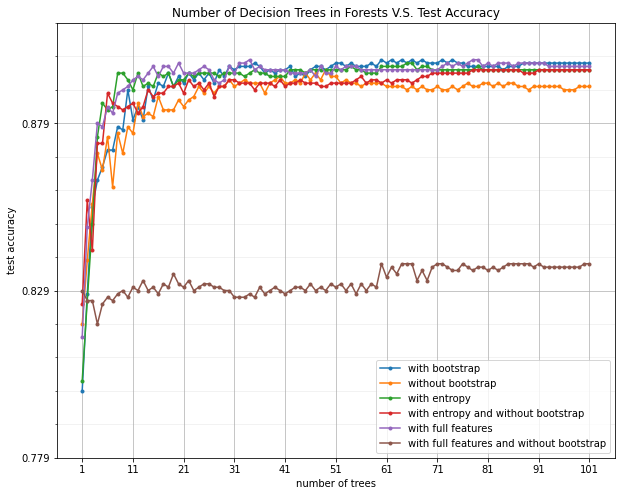

best accuracy: 0.898 
error rate:  0.102


In [0]:
# test on the data from my CSE151 class
train_data, train_label = read_data(train_file)
test_data, test_label = read_data(test_file)
compare_forests(train_data, train_label, test_data, test_label)

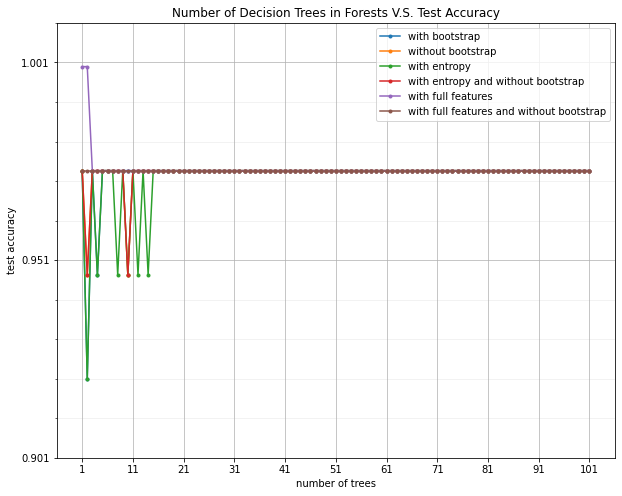

best accuracy: 0.9736842105263158 
error rate:  0.026


In [0]:
# test on the iris data on sklearn.datasets
iris = datasets.load_iris()
train_data, test_data, train_label, test_label = train_test_split(iris.data, iris.target, random_state=0)
compare_forests(train_data, train_label, test_data, test_label)

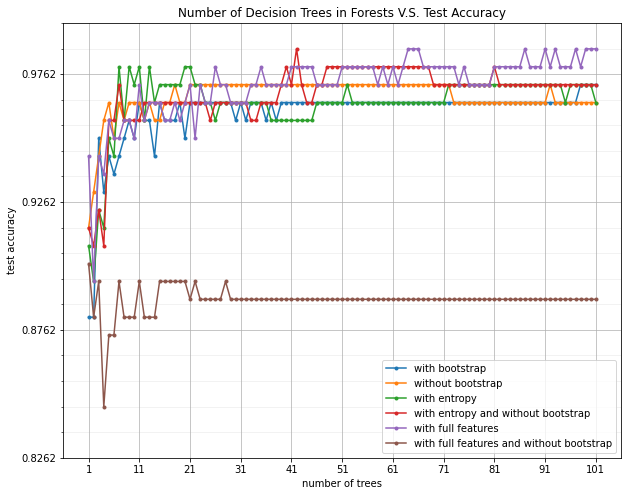

best accuracy: 0.972027972027972 
error rate:  0.028


In [0]:
# test on the breast cancer data on sklearn.datasets
bc = datasets.load_breast_cancer()
train_data, test_data, train_label, test_label = train_test_split(bc.data, bc.target, random_state=0)
compare_forests(train_data, train_label, test_data, test_label)

### • Conslusion
By training and comparing six types of random decision forests, we can conclude that with either bootstrap or only sqrt of the total number of features, the resulting random decision forests can have low enough correlations between each individual decision trees so that the emsemble classifier can have great performance. However, if none of the bagging and feature randomness are employed, then each constituent decision tree are largely correlated to each other. As a result, they are more likely to make the same mistakes together and thus unable to produce highly predictive result through voting between trees. This result corresponds with this [website](https://towardsdatascience.com/understanding-random-forest-58381e0602d2) at towardsdatascience.com. 

As for effect of using entropy/information gain as the criterion for tree growing, it can be found based on the graphs that sometimes using entropy can produce better generalization accuracy with low number of decision trees in the forests. Nevertheless, as the number of trees increase in the forests, their generalization accuacy tends to become similar.
